## Camelyon16 Breast Cancer Prediction - Final

In [ ]:
# Install the OpenSlide C library and Python bindings
# After installing these libraries, use `Runtime -> restart and run all` on the menu
!apt-get install openslide-tools
!pip install openslide-python

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
import shutil
from PIL import Image
from skimage.color import rgb2gray

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [57]:
# Download an example slide and tumor mask

slide_path = 'tumor_084.tif' 
tumor_mask_path = 'tumor_084_mask.tif' 

slides_dir = '/content/drive/MyDrive/DeepLearningProjectImages/slideslocal/'

slide_url = '/content/drive/MyDrive/DeepLearningProjectImages/slideslocal/%s' % slide_path
mask_url = '/content/drive/MyDrive/DeepLearningProjectImages/slideslocal/%s' % tumor_mask_path

# Download the whole slide image
if not os.path.exists(slide_path):
  !curl -O $slide_url

# Download the tumor mask
if not os.path.exists(tumor_mask_path):
  !curl -O $mask_url


curl: (3) <url> malformed
curl: (3) <url> malformed
 /content/drive/MyDrive/DeepLearningProjectImages/slides/tumor_084.tif
 /content/drive/MyDrive/DeepLearningProjectImages/slideslocal/tumor_075.tif


In [58]:
slide = open_slide(slide_url)
print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                        slide.level_dimensions[0][0], 
                                                        slide.level_dimensions[0][1]))

tumor_mask = open_slide(mask_url)
print ("Read tumor mask from %s" % (tumor_mask_path))

print("Slide includes %d levels", len(slide.level_dimensions))
for i in range(9):
    print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                             slide.level_dimensions[i], 
                                                             slide.level_downsamples[i]))
    assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
    assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

# Verify downsampling works as expected
width, height = slide.level_dimensions[7]
assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]

Read WSI from tumor_075.tif with width: 90112, height: 78848
Read tumor mask from tumor_075_mask.tif
Slide includes %d levels 9
Level 0, dimensions: (90112, 78848) downsample factor 1
Level 1, dimensions: (45056, 39424) downsample factor 2
Level 2, dimensions: (22528, 19712) downsample factor 4
Level 3, dimensions: (11264, 9856) downsample factor 8
Level 4, dimensions: (5632, 4928) downsample factor 16
Level 5, dimensions: (2816, 2464) downsample factor 32
Level 6, dimensions: (1408, 1232) downsample factor 64
Level 7, dimensions: (704, 616) downsample factor 128
Level 8, dimensions: (352, 308) downsample factor 256


In [4]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False, mask=False):
    downsample_factor = slide.level_downsamples[level]
    x *= int(downsample_factor)
    y *= int(downsample_factor)
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    if mask: im = im[:,:,0]
    return im

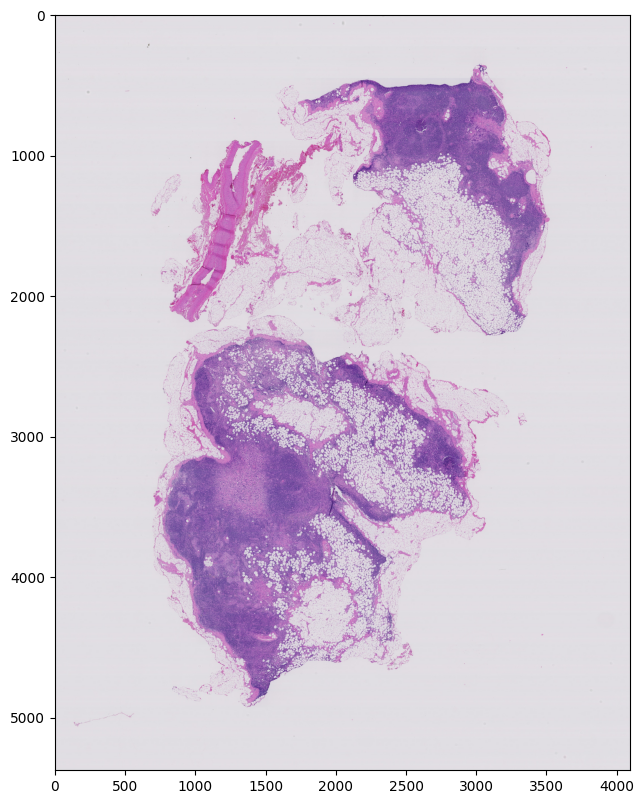

In [7]:
slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=4, 
                         width=slide.level_dimensions[4][0], 
                         height=slide.level_dimensions[4][1])

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)

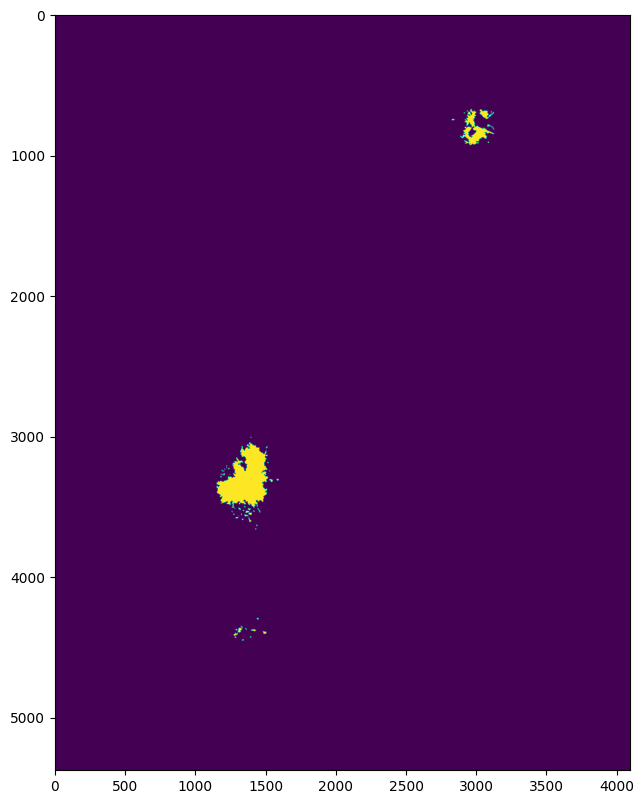

In [8]:
# Example: read the entire mask at the same zoom level
mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=4, 
                        width=slide.level_dimensions[4][0], 
                        height=slide.level_dimensions[4][1],
                        mask=True)


plt.figure(figsize=(10,10), dpi=100)
plt.imshow(mask_image)

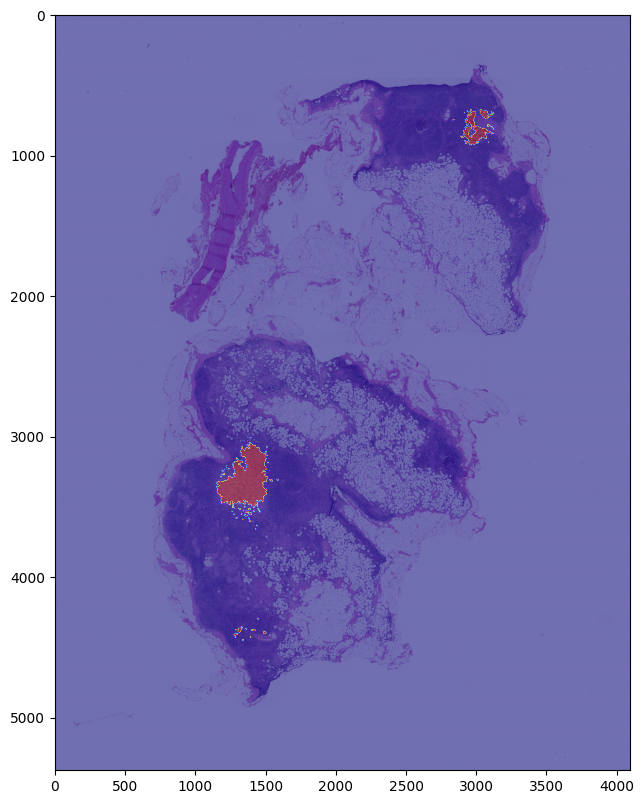

In [9]:
# Overlay them. The idea is that the mask shows the region of the slide that
# contain cancerous cells.
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='jet', alpha=0.5) # Red regions contains cancer.

In [5]:
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return list(zip(indices[0], indices[1]))

def get_tissue_pct(img_patch, intensity=0.8):
    tissue_pixels = find_tissue_pixels(img_patch, intensity)
    percent_tissue = len(tissue_pixels) / float(img_patch.shape[0] * img_patch.shape[1]) * 100
    return percent_tissue
  
percent_tissue = get_tissue_pct(slide_image)
print ("tissue_pixels pixels (%.1f percent of the image)" % ( percent_tissue)) 

def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[int(x)][int(y)] = color
    return masked

tissue_regions = apply_mask(slide_image, find_tissue_pixels(slide_image))
plt.imshow(tissue_regions)


In [6]:
#Create slide pairs
import random

slides_dir = '/content/drive/MyDrive/DeepLearningProjectImages/slideslocal/'
arr = list(os.listdir(slides_dir))
# get file names
slides_list = sorted([i for i in arr if i.find("_mask")<0 and i.find('.tif')>-1])
masks_list = sorted([i for i in arr if i.find("_mask")>-1 and i.find('.tif')>-1])

# make pairs
pairs_list = []
for ind, slide_name in enumerate(slides_list):
  for mask_name in masks_list:
    if(mask_name[:9]+".tif">slide_name): break
    elif(mask_name[:9]+".tif"==slide_name): 
      pairs_list.append((slide_name, mask_name))

#shuffle pairs list with seed
random.Random(5).shuffle(pairs_list)

print(f"{len(pairs_list)} pairs found")

21 pairs found


In [7]:
print(pairs_list)

[('tumor_110.tif', 'tumor_110_mask.tif'), ('tumor_016.tif', 'tumor_016_mask.tif'), ('tumor_084.tif', 'tumor_084_mask.tif'), ('tumor_096.tif', 'tumor_096_mask.tif'), ('tumor_078.tif', 'tumor_078_mask.tif'), ('tumor_057.tif', 'tumor_057_mask.tif'), ('tumor_023.tif', 'tumor_023_mask.tif'), ('tumor_031.tif', 'tumor_031_mask.tif'), ('tumor_019.tif', 'tumor_019_mask.tif'), ('tumor_002.tif', 'tumor_002_mask.tif'), ('tumor_005.tif', 'tumor_005_mask.tif'), ('tumor_094.tif', 'tumor_094_mask.tif'), ('tumor_059.tif', 'tumor_059_mask.tif'), ('tumor_012.tif', 'tumor_012_mask.tif'), ('tumor_075.tif', 'tumor_075_mask.tif'), ('tumor_081.tif', 'tumor_081_mask.tif'), ('tumor_001.tif', 'tumor_001_mask.tif'), ('tumor_091.tif', 'tumor_091_mask.tif'), ('tumor_064.tif', 'tumor_064_mask.tif'), ('tumor_035.tif', 'tumor_035_mask.tif'), ('tumor_101.tif', 'tumor_101_mask.tif')]


In [22]:
#extract patches & create directory

root_dir = '/content/drive/MyDrive/DeepLearningProjectImages/'

def create_directory_structure(level=None):
  if not level:
    raise Exception('No level specified!')
  #directory structure
  lvl_dir = os.path.join(root_dir, 'level'+str(level))
  lvl_train_dir = os.path.join(lvl_dir, 'train') 
  lvl_test_dir = os.path.join(lvl_dir, 'test') 
  lvl_train_malignant_dir = os.path.join(lvl_train_dir, 'malignant')
  lvl_train_benign_dir = os.path.join(lvl_train_dir, 'benign')
  lvl_test_malignant_dir = os.path.join(lvl_test_dir, 'malignant')
  lvl_test_benign_dir = os.path.join(lvl_test_dir, 'benign')

  #mkdir
  os.mkdir(lvl_dir)
  os.mkdir(lvl_train_dir)
  os.mkdir(lvl_test_dir)
  os.mkdir(lvl_train_malignant_dir)
  os.mkdir(lvl_train_benign_dir)
  os.mkdir(lvl_test_malignant_dir)
  os.mkdir(lvl_test_benign_dir)
  print('directory structure created. returning train & test dir.')
  return lvl_train_dir, lvl_test_dir

In [ ]:
#1: Prevent from going off edge
#2: Save only if within center

In [88]:
# f = plt.figure(figsize=(20,10))
def load_image_patches_to_dir(dir_path=None,width=192, height=168, level=2, tissue_pct_threshold=25):
  def crop_center(img,cropx,cropy):
    y,x = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]
  
  if not dir_path:
    raise Exception('No dir path specified!')
  benign_count = 0
  malignant_count = 0
  
  #store path to store patches
  malignant_dir = os.path.join(dir_path, 'malignant')
  benign_dir = os.path.join(dir_path, 'benign')
  
  #store random malignant image & mask to display at the end
  show_mal_img = None
  show_mal_mask = None
  #store random benign image & mask to display at the end
  show_ben_img = None
  show_ben_mask = None

  #for each of the first 17 images (save 4 for test)
  for slide_fname, mask_fname in pairs_list[:17]:
    print('saving from image '+slide_fname)
    slide_url = slides_dir+slide_fname
    mask_url = slides_dir+mask_fname
    #open slides
    tissue_slide = open_slide(slide_url)
    mask_slide = open_slide(mask_url)
    slide_width = tissue_slide.level_dimensions[level][0]
    slide_height = tissue_slide.level_dimensions[level][1]

    for y in range(0,slide_height,height):
      #check we're within boundaries
      if y+height > tissue_slide.level_dimensions[level][1]: 
            # print('y boundary: ', y)
            continue
      for x in range(0,slide_width,width):
        #check we're within boundaries
        if x+width > tissue_slide.level_dimensions[level][0]: 
            # print('x boundary:', x)
            continue

        #read slide patches
        patch = read_slide(tissue_slide, x, y, level, width=width, height=height)
        mask = read_slide(mask_slide, x, y, level, width=width, height=height, mask=True)

        #check if mask center 128x128 has tumor
        mask_check = crop_center(mask, 128, 128)
        tumor_pixels = np.where(mask_check>0)
        tumor_pixels = list(zip(tumor_pixels[0], tumor_pixels[1]))

        if len(tumor_pixels)>0:
          #malignant
          show_mal_img = patch
          show_mal_mask = mask
          #save image
          save_url = os.path.join(malignant_dir,f"{slide_fname.replace('.tif','')}_x={str(x)}y={str(y)}.png")
          
          im = Image.fromarray(patch)
          im.save(save_url)
          malignant_count+=1
        else:
          #benign
          
          #save image only if not mostly grey
          tissue_pct = get_tissue_pct(patch)

          if tissue_pct>=tissue_pct_threshold:
            print('not grey')
            show_ben_img = patch
            show_ben_mask = mask

            save_url = os.path.join(benign_dir,f"{slide_fname.replace('.tif','')}_x={str(x)}y={str(y)}.png")
            
            im = Image.fromarray(patch)
            im.save(save_url)
            benign_count +=1
    print('saved image '+slide_fname)  

  print(f"Images loaded from level {level}. {benign_count} benign images, {malignant_count} malignant images")
  #SHOW IMAGE SAMPLES
  plt.figure(figsize=(10,10))
  plt.subplot(2,2,1)
  plt.imshow(show_mal_img)
  plt.title('malignant patch')
  plt.subplot(2,2,2)
  plt.imshow(show_mal_mask)
  plt.title('malignant mask')
  plt.subplot(2,2,3)
  plt.imshow(show_ben_img)
  plt.title('benign patch')
  plt.subplot(2,2,4)
  plt.imshow(show_ben_mask)
  plt.title('benign mask')
      

In [ ]:
#----------DEEP LEARNING HAPPENING BELOW---------

In [16]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory, image
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import math

In [17]:
def plot_history(history, epochs):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

In [18]:
#COLOR MAPS FOR OVERLAY
reds_colormap = [(255,255,255), (252, 185, 160), (251, 121, 90), (223, 45, 38), (170, 16, 22), (130, 6, 15)]
yellow_red_colormap = [(255, 246, 181), (254, 216, 122), (254, 193, 94), (223, 45, 38), (170, 16, 22), (130, 6, 15)]

In [48]:
test_slides = pairs_list[18:]

def slide_predict(slide_pair, model, patch_size=(192,168), level=2, colormap=reds_colormap):

  def crop_center(img,cropx,cropy):
    y,x,z = img.shape
    print(x, y, z)
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)   
    print(img[starty:starty+cropy,startx:startx+cropx,:])
    return img[starty:starty+cropy,startx:startx+cropx,:]

  #open slides
  test_slide_fname, test_mask_fname = slide_pair
  test_slide_url = slides_dir+test_slide_fname
  test_mask_url = slides_dir+test_mask_fname

  tissue_slide = open_slide(test_slide_url)
  mask_slide = open_slide(test_mask_url)
  #get dims
  slide_width = tissue_slide.level_dimensions[level][0]
  slide_height = tissue_slide.level_dimensions[level][1]
  patch_width, patch_height = patch_size
  

  #initialize white heatmap
  heatmap = np.zeros([slide_height, slide_width, 3], dtype=np.uint8)
  heatmap.fill(255)

  for y in range(0, slide_height, patch_height):
    for x in range(0, slide_width, patch_width):
      #read slide patches
      patch = read_slide(tissue_slide, x, y, level, width=patch_width, height=patch_height)
      mask = read_slide(mask_slide, x, y, level, width=patch_width, height=patch_height, mask=True)
      #Prep image for prediction
      patch_arr = image.img_to_array(patch)
      #Select only center
      # patch_arr = crop_center(patch_arr, 128, 128)
      patch_arr = tf.expand_dims(patch_arr, 0)      #create a batch
      #Predict
      pred = model.predict(patch_arr)
      pred_label = class_names[np.argmax(pred)]
      pred_confidence = 100*np.max(pred)

      #Colour heatmap if malignant
      if pred_label == 'malignant':
        heatmap_square = heatmap[y:y+patch_height, x:x+patch_width,:]
        color_bucket = math.ceil(max(0, pred_confidence-50)/10)
        r, g, b = colormap[color_bucket]
        heatmap_square[:,:,0].fill(r)
        heatmap_square[:,:,1].fill(g)
        heatmap_square[:,:,2].fill(b)

  plt.figure(figsize=(30,30))
  
  print('displaying image, width: ', slide_width, ' height: ', slide_height)
  #show overlay
  plt.subplot(1, 2, 1)
  plt.title('overlayed heatmap')
  #save image
  slide_img = read_slide(tissue_slide, 0, 0, level, slide_width, slide_height)
  im1 = plt.imshow(slide_img, interpolation='none')
  im2 = plt.imshow(heatmap, cmap='Reds', alpha=0.4)
  plt.axis("on")

  #show mask
  plt.subplot(1, 2, 2)
  plt.title('mask')
  mask_img = read_slide(mask_slide, 0, 0, level, slide_width, slide_height, mask=True)
  plt.imshow(mask_img)
  plt.axis("on")

      


In [ ]:
#TRY A MORE BALANCED DATASET

In [ ]:
#FULL PIPELINE

In [29]:
class_names = ['benign', 'malignant']

In [23]:
#Create Directory
# balanced_train_dir, balanced_test_dir = create_directory_structure(level='2')
lvl_dir = os.path.join(root_dir, 'level'+str('2'))
balanced_train_dir = os.path.join(lvl_dir, 'train') 

In [ ]:
#Load Patches Into Directory
# load_image_patches_to_dir(
#     dir_path=balanced_train_dir,
#     width=192,
#     height=168,
#     level=2
#     )

In [94]:
#BALANCE DATASETS

benign_path = os.path.join(balanced_train_dir,'benign')
malignant_path = os.path.join(balanced_train_dir,'malignant')
malignant_length = len(os.listdir(malignant_path))

#randomly shuffle & pick benign slides length = malignant slides
benign_list = os.listdir(benign_path)
random.shuffle(benign_list)
benign_list = benign_list[:malignant_length]
print(len(benign_list), malignant_length)
# for fname in os.listdir(benign_path)[malignant_length:]:
#   os.remove(os.path.join(benign_path,fname))

6292 6292


In [109]:
#Deep Learning
def run_dl_pipeline(train_dir=None, BATCH_SIZE=32, IMG_SIZE=(192, 168), model=None, epochs=10):
    if not train_dir:
      raise Exception('train_dir not specified')
    IMG_SHAPE = (*IMG_SIZE, 3)
    #Set train & val datasets
    train_ds = image_dataset_from_directory(train_dir,
                                          batch_size=BATCH_SIZE,
                                          image_size=IMG_SIZE,
                                          shuffle=True,
                                          seed=1337,
                                          validation_split=0.2,
                                          subset='training')
    val_ds = image_dataset_from_directory(train_dir,
                                          batch_size=BATCH_SIZE,
                                          image_size=IMG_SIZE,
                                          shuffle=True,
                                          seed=1337,
                                          validation_split=0.2,
                                          subset='validation')
    class_names = train_ds.class_names
    print(class_names)
    val_batches = tf.data.experimental.cardinality(val_ds)
    test_ds = val_ds.take(val_batches // 4)
    val_ds = val_ds.skip(val_batches // 4)

    print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
    print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

    class_names = train_ds.class_names
    print(class_names)
    #Optimize performance
    train_ds = train_ds.cache().prefetch(tf.data.AUTOTUNE)
    val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)
    test_ds = test_ds.cache().prefetch(tf.data.AUTOTUNE)

    #Create checkpoint to save progress
    lvl_root_dir = '/'.join(train_dir.split('/')[:-1])
    checkpoint_dir = os.path.join(lvl_root_dir, 'checkpoints')
    if os.path.exists(checkpoint_dir): shutil.rmtree(checkpoint_dir)
    os.mkdir(checkpoint_dir)
    print('checkpoint dir: ', checkpoint_dir)
    checkpoint_fpath = os.path.join(checkpoint_dir,"cp")

    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_fpath,
                                                    save_weights_only=True,
                                                    verbose=0)
    
    #Enable Early Stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=3
    )

    #Create model
    if not model:
        model = Sequential([
            layers.experimental.preprocessing.RandomFlip("horizontal"),
            layers.experimental.preprocessing.RandomRotation(0.1),
            layers.experimental.preprocessing.Rescaling(1./255, input_shape=IMG_SHAPE),
            layers.Conv2D(128, 3, padding='same', activation='relu'),
            layers.MaxPooling2D(),
            layers.Dropout(0.3),
            layers.Conv2D(256, 3, padding='same', activation='relu'),
            layers.MaxPooling2D(),
            layers.Dropout(0.3),
            layers.Conv2D(512, 3, padding='same', activation='relu'),
            layers.MaxPooling2D(),
            layers.Dropout(0.5),
            layers.Flatten(),
            layers.Dense(2, activation='sigmoid')
        ])

    model.compile(optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy'])
    
    #Dataset is likely imbalanced. How can we fix this?
    num_benign = len(os.listdir(os.path.join(train_dir,'benign')))           #class 0
    num_malignant = len(os.listdir(os.path.join(train_dir,'benign')))     #class 1
    num_total = num_benign+num_malignant
    print(f"Total Training Samples: {num_total}, Malignant Training Samples: {num_malignant}, Benign Training Samples: {num_benign}")
    # Specify class weights to weight malignant samples more heavily
    weight_class_0 = (1/num_benign)*(num_total)/2.0
    weight_class_1 = (1/num_malignant)*(num_total)/2.0

    print(f'Benign Weight: {weight_class_0}, Malignant Weight: {weight_class_1}')
    
    #Train model
    class_weights = {0:weight_class_0, 1:weight_class_1}

    weighted_model = model
    weighted_history = weighted_model.fit(
      train_ds,
      validation_data=val_ds,
      epochs=epochs,
      callbacks=[cp_callback, early_stopping],
      class_weight=class_weights
    )

    

    #Run predictions on a slide
    # slide_predict(slide_pair=test_slides[0], model=weighted_model, level=2, colormap=yellow_red_colormap)

    #PLOT HISTORY
    # plot_history(weighted_history, epochs)

    return weighted_model, train_ds, val_ds, test_ds

In [110]:
weighted_model, train_ds, val_ds, test_ds = run_dl_pipeline(
    train_dir=balanced_train_dir,
    epochs=15,
    BATCH_SIZE=32
)

Found 12584 files belonging to 2 classes.
Using 10068 files for training.
Found 12584 files belonging to 2 classes.
Using 2516 files for validation.
['benign', 'malignant']
Number of validation batches: 60
Number of test batches: 19
['benign', 'malignant']
checkpoint dir:  /content/drive/MyDrive/DeepLearningProjectImages/level2/checkpoints
Total Training Samples: 12584, Malignant Training Samples: 6292, Benign Training Samples: 6292
Benign Weight: 1.0, Malignant Weight: 1.0
Epoch 1/15
315/315 [==============================] - 43s 131ms/step - loss: 0.6930 - accuracy: 0.7355 - val_loss: 0.3322 - val_accuracy: 0.8784
Epoch 2/15
315/315 [==============================] - 19s 61ms/step - loss: 0.2596 - accuracy: 0.8975 - val_loss: 0.5845 - val_accuracy: 0.8145
Epoch 3/15
315/315 [==============================] - 19s 61ms/step - loss: 0.2301 - accuracy: 0.9139 - val_loss: 0.3374 - val_accuracy: 0.8847
Epoch 4/15
315/315 [==============================] - 19s 61ms/step - loss: 0.2227 - acc

displaying image, width:  34816  height:  17920


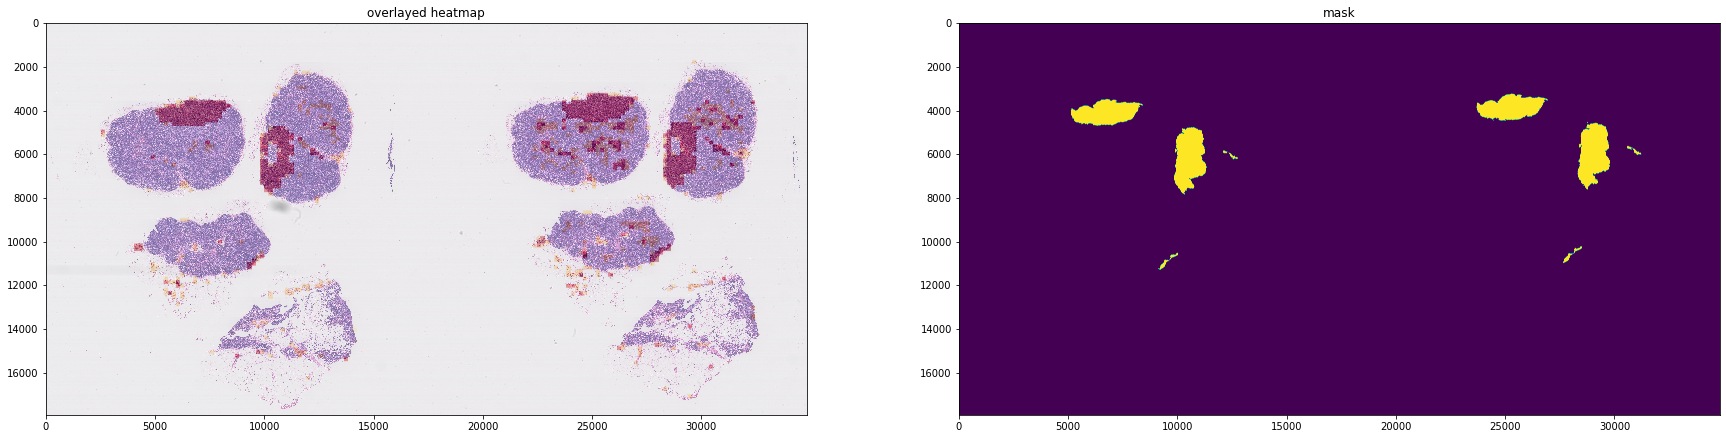

In [117]:
slide_predict(slide_pair=test_slides[2], model=weighted_model, level=2, colormap=yellow_red_colormap)

In [24]:
#RELOAD MODEL FROM CHECKPOINT
weighted_model = Sequential([
            layers.experimental.preprocessing.RandomFlip("horizontal"),
            layers.experimental.preprocessing.RandomRotation(0.1),
            layers.experimental.preprocessing.Rescaling(1./255, input_shape=(192, 168, 3)),
            layers.Conv2D(128, 3, padding='same', activation='relu'),
            layers.MaxPooling2D(),
            layers.Dropout(0.3),
            layers.Conv2D(256, 3, padding='same', activation='relu'),
            layers.MaxPooling2D(),
            layers.Dropout(0.3),
            layers.Conv2D(512, 3, padding='same', activation='relu'),
            layers.MaxPooling2D(),
            layers.Dropout(0.5),
            layers.Flatten(),
            layers.Dense(2, activation='sigmoid')
        ])

weighted_model.compile(optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy'])

In [25]:
lvl_root_dir = '/'.join(balanced_train_dir.split('/')[:-1])
checkpoint_dir = os.path.join(lvl_root_dir, 'checkpoints')
checkpoint_fpath = os.path.join(checkpoint_dir,"cp")

In [26]:
weighted_model.load_weights(checkpoint_fpath)

displaying image, width:  15360  height:  13440


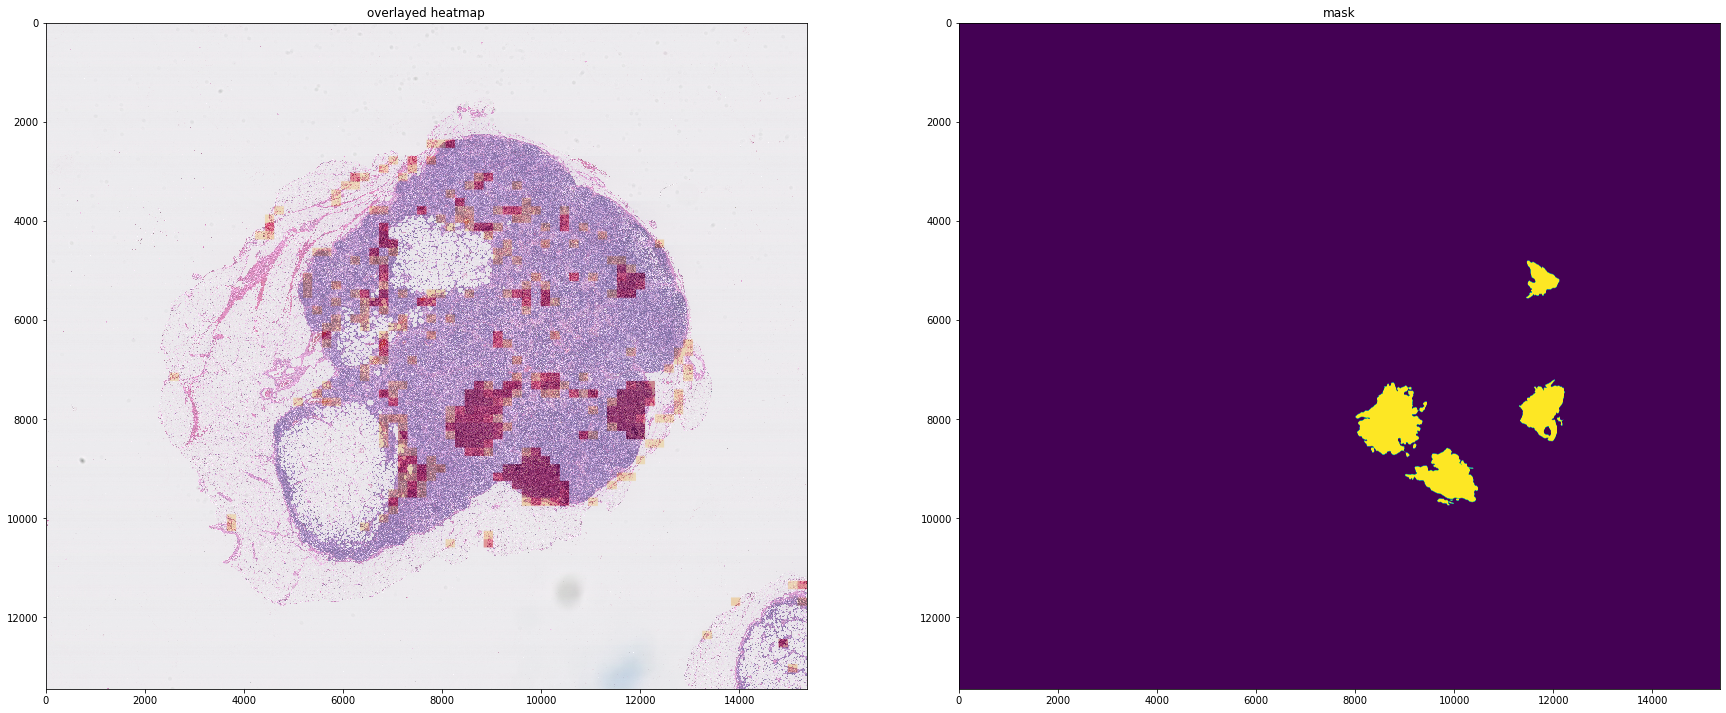

In [30]:
slide_predict(slide_pair=test_slides[0], model=weighted_model, level=2, colormap=yellow_red_colormap)

displaying image, width:  22528  height:  19712


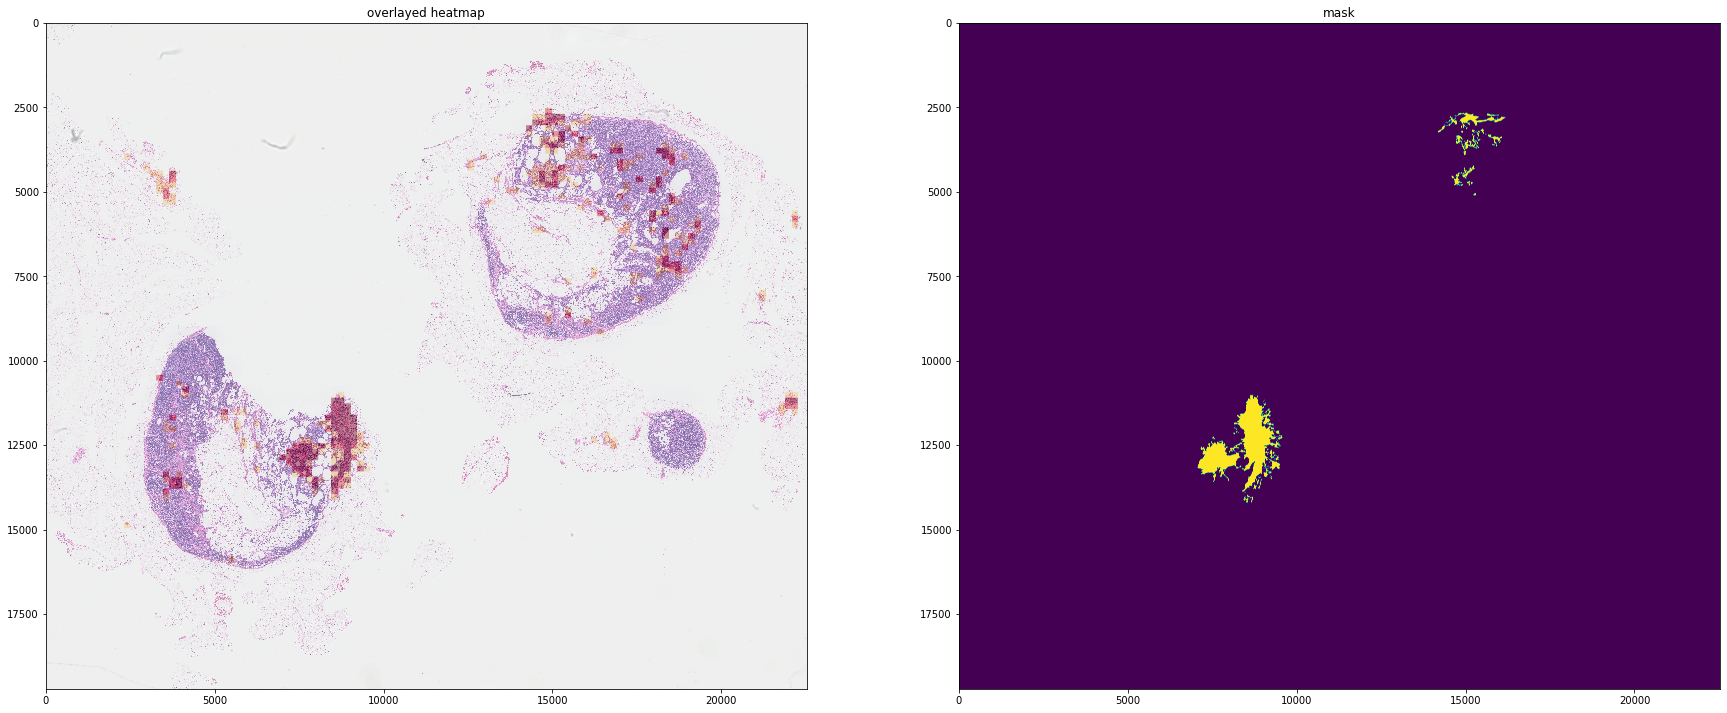

In [59]:
slide_predict(slide_pair=test_slides[1], model=weighted_model, level=2, colormap=yellow_red_colormap)

In [118]:
weighted_model.evaluate(test_ds)

19/19 [==============================] - 5s 190ms/step - loss: 0.1550 - accuracy: 0.9457


[0.1550067663192749, 0.9457237124443054]

# Hyperparameter Tuning

In [60]:
pip install -q -U keras-tuner

     |████████████████████████████████| 71kB 5.5MB/s 


In [61]:
import kerastuner as kt

In [62]:
def tuned_model_builder(hp):
    IMG_SHAPE = (192, 168, 3)
    model = tf.keras.Sequential([layers.experimental.preprocessing.Rescaling(1./255, input_shape=IMG_SHAPE)])
    
    #tune convolution model params
    conv1_filters=hp.Int(
      'num_filters1',
      min_value=96,
      max_value=256,
      step=32,
      default=96,
    )
    conv1_kernels = hp.Int(
        'kernel_size1',
        min_value=3,
        max_value=6,
        step=1,
        default=4
    )
    conv2_filters=hp.Int(
      'num_filters2',
      min_value=128,
      max_value=288,
      step=32,
      default=128,
    )
    conv2_kernels = hp.Int(
        'kernel_size2',
        min_value=3,
        max_value=6,
        step=1,
        default=4
    )
    #tune dropout
    dropout_rate = hp.Float(
        'dropout_rate',
        min_value=0.1,
        max_value=0.5,
        default=0.15,
        step=0.1
    )
    rot_rate = hp.Float(
        'rot_rate',
        min_value=0.1,
        max_value=0.5,
        default=0.15,
        step=0.1
    )

    #add to model with tuned params
    model.add(layers.experimental.preprocessing.RandomFlip("horizontal"))
    model.add(layers.experimental.preprocessing.RandomRotation(rot_rate))
    model.add(layers.Conv2D(filters=conv1_filters, kernel_size=conv1_kernels, padding='same', activation='relu'))
    model.add(layers.MaxPooling2D())
    model.add(layers.Dropout(rate=dropout_rate))
    model.add(layers.Conv2D(filters=conv2_filters, kernel_size=conv2_kernels, padding='same', activation='relu'))
    model.add(layers.MaxPooling2D())
    model.add(layers.Dropout(rate=dropout_rate))
    model.add(layers.Flatten())
    # model.add(layers.Conv2D(filters=conv3_filters, kernel_size=conv3_kernel, padding='same', activation=conv3_activation))
    model.add(layers.Dense(2, activation='softmax'))

    #tune compile params
    # learning_rate = hp.Float(
    #     'learning_rate',
    #     min_value = 1e-5,
    #     max_value = 1e-2,
    #     sampling = 'LOG',
    #     default = 4e-4
    # )
    
    model.compile(
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
      metrics=['accuracy']
    )

    return model

In [63]:
tuner = kt.Hyperband(tuned_model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt2')

In [64]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

In [ ]:
tuner.search(train_ds, validation_data=val_ds, epochs=50, callbacks=[stop_early])

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(
f"""The hyperparameter search is complete. \n
CONV 1 Filters: {best_hps.get('num_filters1')}\n
CONV 1 Kernel Size: {best_hps.get('kernel_size1')}\n
CONV 2 Filters: {best_hps.get('num_filters2')}\n
CONV 2 Kernel Size: {best_hps.get('kernel_size2')}\n
Best dropout rate is {best_hps.get('dropout_rate')}\n
""")

In [ ]:
opt_model = tuner.get_best_models(num_models=1)[0]
opt_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
    metrics=['accuracy']
  )

history = opt_model.fit(train_ds, validation_data=val_ds, epochs=50, callbacks=[stop_early])

In [ ]:
opt_model.evaluate(test_ds)

In [ ]:
slide_predict(test_slides[0], opt_model, level=2, colormap=yellow_red_colormap)

In [ ]:
pairs_list[9]

In [ ]:
slide = open_slide('/content/drive/MyDrive/DeepLearningProjectImages/slides/'+pairs_list[9][1])
# slide = read_slide(tissue_slide, 0, 0, level, width=width, height=height)
slide.level_dimensions


In [ ]:
slide_predict(pairs_list[9], opt_model, level=2, colormap=yellow_red_colormap)

In [ ]:
print(pairs_list[9])

# Metrics

In [67]:
train_ds = image_dataset_from_directory(balanced_train_dir,
                                          batch_size=32,
                                          image_size=(192, 168),
                                          shuffle=True,
                                          seed=1337,
                                          validation_split=0.2,
                                          subset='training')
val_ds = image_dataset_from_directory(balanced_train_dir,
                                      batch_size=32,
                                      image_size=(192, 168),
                                      shuffle=True,
                                      seed=1337,
                                      validation_split=0.2,
                                      subset='validation')
class_names = train_ds.class_names
print(class_names)
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 4)
val_ds = val_ds.skip(val_batches // 4)

Found 12584 files belonging to 2 classes.
Using 10068 files for training.
Found 12584 files belonging to 2 classes.
Using 2516 files for validation.
['benign', 'malignant']


In [68]:
test_img = []
test_labels = []

for img, label in test_ds:
  test_img.append(img.numpy())
  test_labels.append(label.numpy())

test_img = np.array(test_img)
test_labels = np.array(test_labels)

In [80]:
test_img = test_img.reshape(608, 192, 168, 3)
test_labels = test_labels.reshape(608)
y_pred = np.argmax(weighted_model.predict(test_img), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

(608,) (608,)
Test set accuracy: 94%


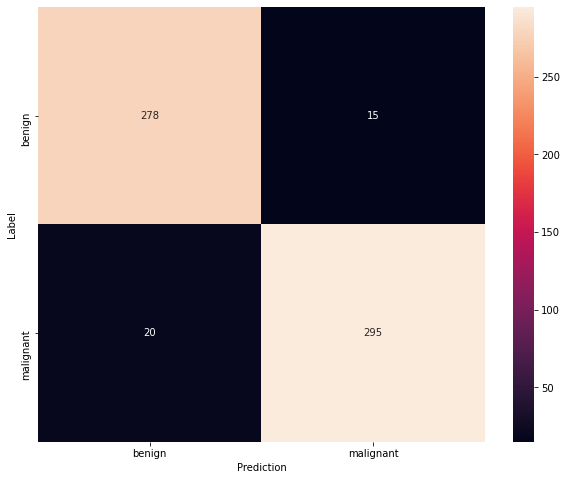

In [83]:
import seaborn as sns

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=class_names, yticklabels=class_names, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [92]:
all_positives = confusion_mtx[0][1]+confusion_mtx[1][1]
true_positives = confusion_mtx[1][1]
print('Precision: ', round(100*(true_positives/all_positives).numpy(),2), '%')

Precision:  95.16 %


In [97]:
false_negatives = confusion_mtx[1][0]
print('Recall: ', round(100*(true_positives/(false_negatives+true_positives)).numpy(),2), '%')

Recall:  93.65 %
